# Analysing results from progressive Apply on CNF
tested benchmarks:
CNF: uf20-01 -- uf20-100

In [ ]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    # "mathtext.default": "regular",  # Use mathtext (math fonts) instead of LaTeX
    # "font.family": "serif",  # Use serif font (like Computer Modern)
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})


In [ ]:
# we create a new dataframe from all report csvs for progressive cnf growth
# aggregated dataframe will look like this:
# benchmark;iterations;bdd_min;bdd_max;bdd_sum;bdd_avg;...
# for each model (bdd,zbdd,tbdd,cbdd,czdd,esrbdd,abdd) there will be 4 aggregated values
# final csv should have as many lines as there were tested benchmarks,
# regardless of how many iterations each benchmark lasted

TEXTSIZE = 20
parent_dir = "./dimacs_analysis/"
aggregated_data = []

for dirpath, _, filenames in os.walk(parent_dir):
    # if filename.endswith('.csv')
    for file in filenames:
        # print(f"dp={dirpath}, fn={file}")
        if not file.endswith('.csv'):
            continue

        benchname = dirpath.split('/')[-1]
        csvpath = os.path.join(dirpath, file)
        df = pd.read_csv(csvpath, sep=";")
        statistics = {
            'benchmark': benchname,
            'iterations': len(df),  # Number of iterations is the number of rows
        }
        for model in ['bdd', 'zbdd', 'tbdd', 'cbdd', 'czdd', 'esr', 'abdd']:
            modelfix = "esrbdd" if model == "esr" else model
            statistics[f'{modelfix}_min'] = df[model].min()
            statistics[f'{modelfix}_max'] = df[model].max()
            statistics[f'{modelfix}_avg'] = df[model].mean()
            statistics[f'{modelfix}'] = df[model].sum()
        aggregated_data.append(statistics)
aggregated_df = pd.DataFrame(aggregated_data)
aggregated_df.to_csv("aggregated_benchmark_data.csv", index=False)

max_iter = aggregated_df['iterations'].max()
longest_benchmarks = aggregated_df[aggregated_df['iterations'] == max_iter]

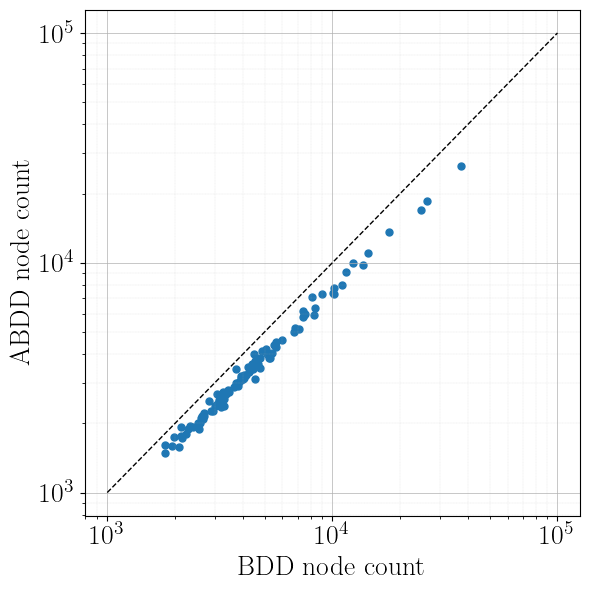

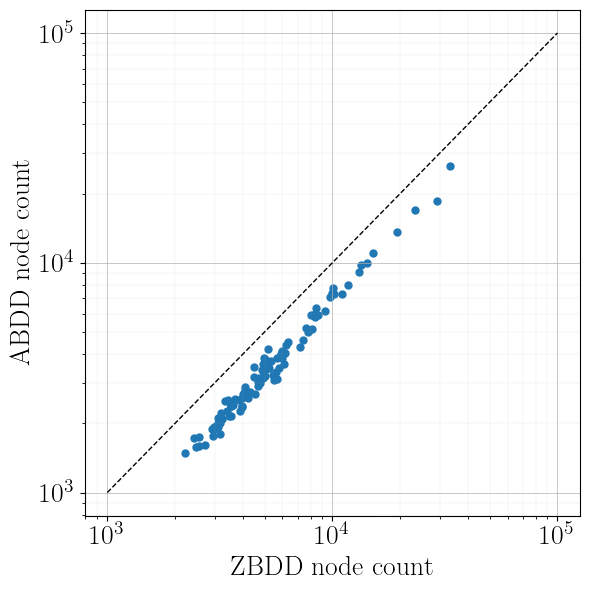

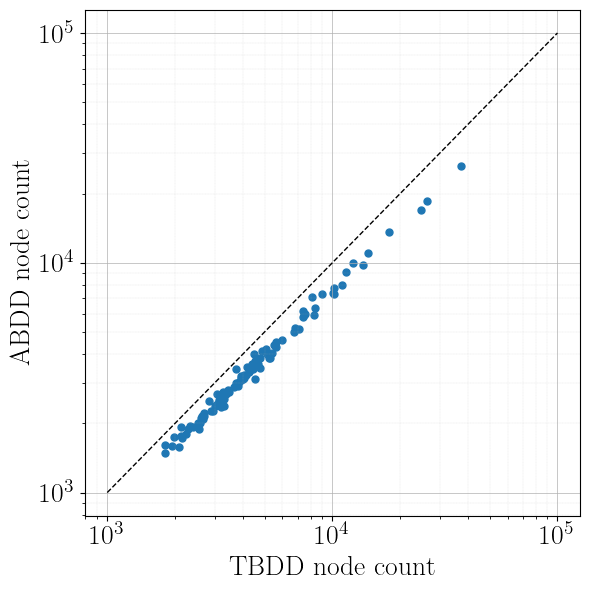

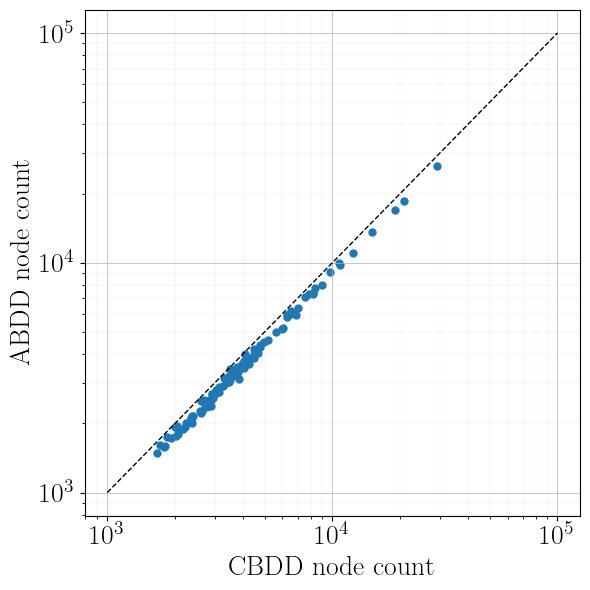

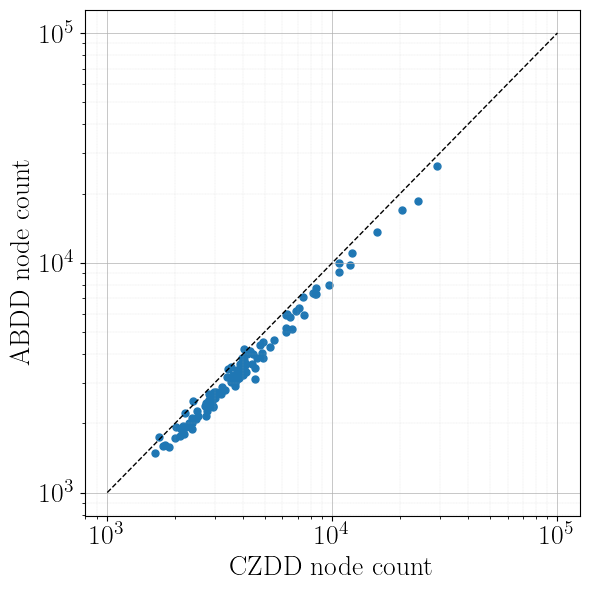

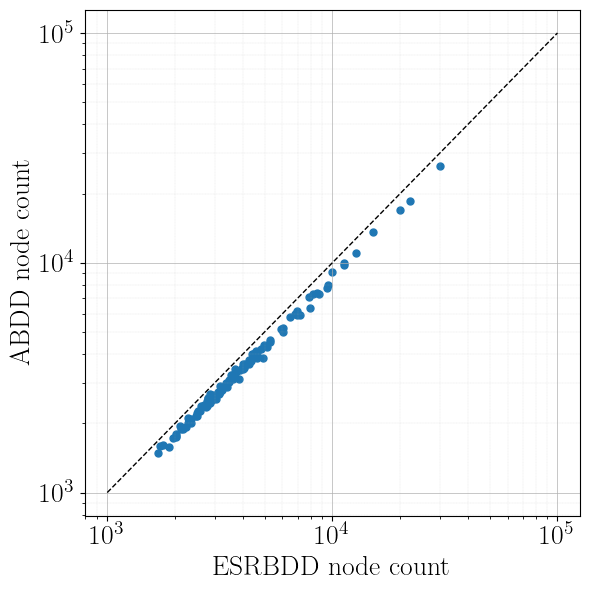

In [3]:
targets = ['bdd', 'zbdd', 'tbdd', 'cbdd', 'czdd', 'esrbdd']

for t in targets:
    plt.figure(figsize=(6,6))
    plt.scatter(
        aggregated_df[t], aggregated_df['abdd'],
        marker='.',
        s=100,
        linewidths=1,
        # color='black'
    )
    plt.xlabel(f"{t.upper()} node count", fontsize=TEXTSIZE)
    plt.ylabel(f"ABDD node count", fontsize=TEXTSIZE)
    xmin, xmax, ymin, ymax = 1e3, 1e6, 1, 1e5

    plt.tick_params(axis='x', labelsize=TEXTSIZE)
    plt.tick_params(axis='y', labelsize=TEXTSIZE)
    plt.xscale("log")
    plt.yscale("log")
    plt.grid(True, which='major', linestyle='solid', linewidth=0.5)
    plt.grid(True, which='minor', linestyle=':', linewidth=0.2)
    lims = [max(xmin, ymin), min(xmax, ymax)]
    plt.plot(lims, lims, 'k--', linewidth=1)
    plt.tight_layout()
    plt.savefig(f"./figures/apply-vs-{t.lower()}.pdf", format='pdf', dpi=300, facecolor='white', edgecolor='r', bbox_inches='tight', pad_inches=0.02)
    plt.show()


In [4]:
sample_benchmark = "uf20-011"  # did not timeout at all
single_benchmark_analysis_path = f"./dimacs_analysis/{sample_benchmark}/report.csv"
single_cnf_df = pd.read_csv(single_benchmark_analysis_path, sep=";")
single_cnf_df.rename(columns={'esr': 'esrbdd'}, inplace=True)

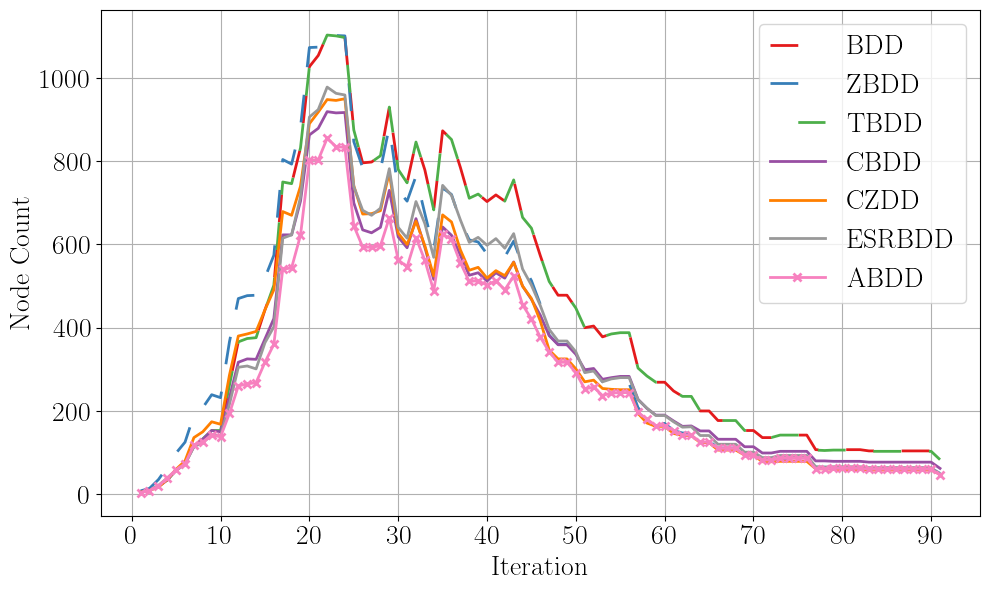

In [ ]:
# Trying to put all line plots into one figure -- not clear, so it was split into 1-1 comparsions with ABDDs

models = ['bdd', 'zbdd', 'tbdd', 'cbdd', 'czdd', 'esrbdd', 'abdd', 'init']
models = ['bdd', 'zbdd', 'tbdd', 'cbdd', 'czdd', 'esrbdd', 'abdd']
x = single_cnf_df.index

# colors = plt.get_cmap('tab10').colors
bright_colors = [
    "#e41a1c",  # bright red
    "#377eb8",  # blue
    "#4daf4a",  # green
    "#984ea3",  # purple
    "#ff7f00",  # orange
    "#999999",  # grey
    "#f781bf",  # pink
    "#ffff33",  # yellow (on dark background only)
    "#a65628",  # brown
]
linestyles = [(0, (10, 10)), (0, (10, 10)), (10, (10, 10)), '-', '-', '-', '-']
# markers = ['o', 's', 'D', '^', 'v', 'P', '*']
markers = [None, None, None, None, None, None, 'x']

def label_f(modelname: str) -> str:
    res = modelname.upper()
    if res == "INIT":
        return "unreduced"
    return res

fig, ax = plt.subplots(figsize=(10, 6))
for i, model in enumerate(models):
    ax.plot(x+1,
            single_cnf_df[model],
            label=label_f(model), 
            color=bright_colors[i % len(bright_colors)],
            linestyle=linestyles[i % len(linestyles)],
            marker=markers[i % len(markers)],
            linewidth=2,
            markersize=6,
            markeredgewidth=2,
            )
ax.set_xticks(range(0, len(single_cnf_df), 10))
ax.tick_params(axis='x', labelsize=TEXTSIZE)
ax.tick_params(axis='y', labelsize=TEXTSIZE)
ax.set_xlabel("Iteration", fontsize=TEXTSIZE)
ax.set_ylabel("Node Count", fontsize=TEXTSIZE)
# ax.set_title("Node Counts per Iteration for benchmark uf20-011")
ax.legend(fontsize=TEXTSIZE)
ax.grid(True)

plt.tight_layout()
plt.savefig(f"./figures/one-apply-analysis.pdf", format='pdf', dpi=300, facecolor='white', edgecolor='r', bbox_inches='tight', pad_inches=0.02)

plt.show()

In [6]:
column_sums = aggregated_df[targets + ['abdd']].sum()

# comparison
for model in targets:
    averages = (aggregated_df[model] - aggregated_df['abdd']) / aggregated_df[model]
    print(model, round(averages.mean() * 100, 2))
print(column_sums)

bdd 20.86
zbdd 33.08
tbdd 20.85
cbdd 10.11
czdd 12.51
esrbdd 12.41
bdd       560790
zbdd      633361
tbdd      560709
cbdd      479900
czdd      497927
esrbdd    496740
abdd      432260
dtype: int64


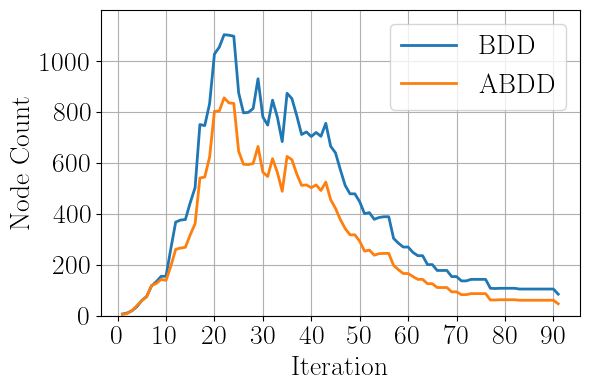

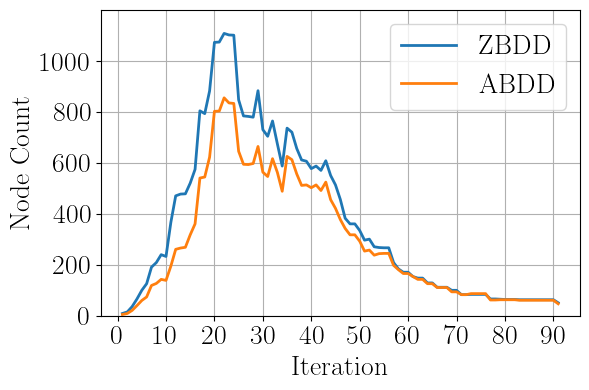

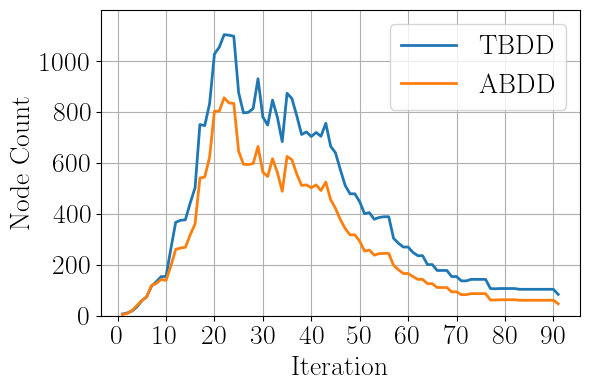

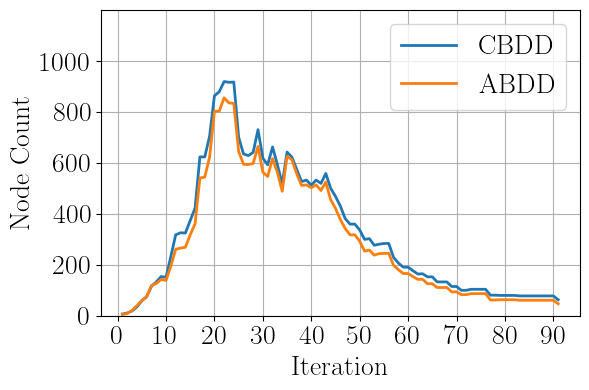

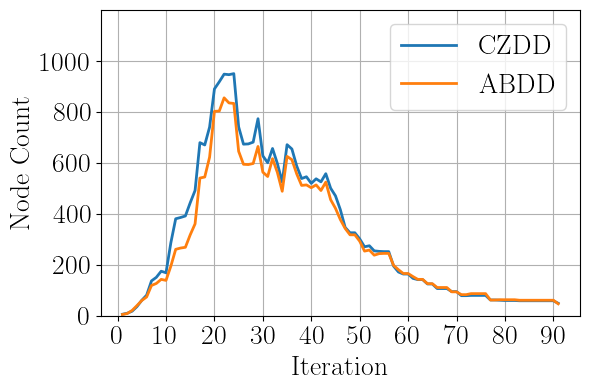

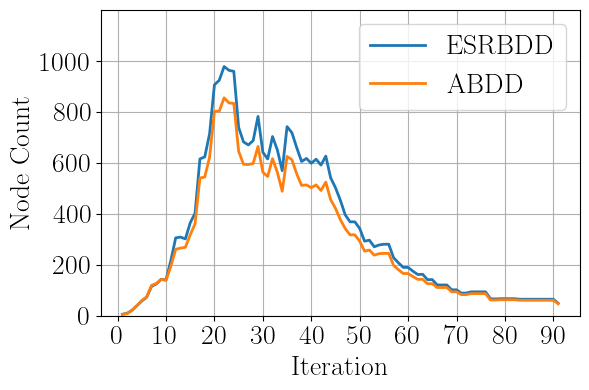

In [7]:
models = ['bdd', 'zbdd', 'tbdd', 'cbdd', 'czdd', 'esrbdd']
x = single_cnf_df.index

def label_f(modelname: str) -> str:
    res = modelname.upper()
    if res == "INIT":
        return "unreduced"
    return res

for i, model in enumerate(models):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(x+1,
            single_cnf_df[model],
            label=label_f(model),
            linewidth=2,
    )
    ax.plot(x+1,
            single_cnf_df['abdd'],
            label=label_f('abdd'), 
            linewidth=2
    )
    ax.set_xticks(range(0, len(single_cnf_df), 10))
    ax.set_yticks(range(0, 1200, 200))
    ax.tick_params(axis='x', labelsize=TEXTSIZE)
    ax.tick_params(axis='y', labelsize=TEXTSIZE)
    ax.set_xlabel("Iteration", fontsize=TEXTSIZE)
    ax.set_ylabel("Node Count", fontsize=TEXTSIZE)
    ax.legend(fontsize=TEXTSIZE)
    ax.grid(True)
    ax.set_ylim(0, 1200)

    plt.tight_layout()
    plt.savefig(f"./figures/one-apply-analysis-vs-{model}.pdf", format='pdf', dpi=300, facecolor='white', edgecolor='r', bbox_inches='tight', pad_inches=0.02)
    plt.show()



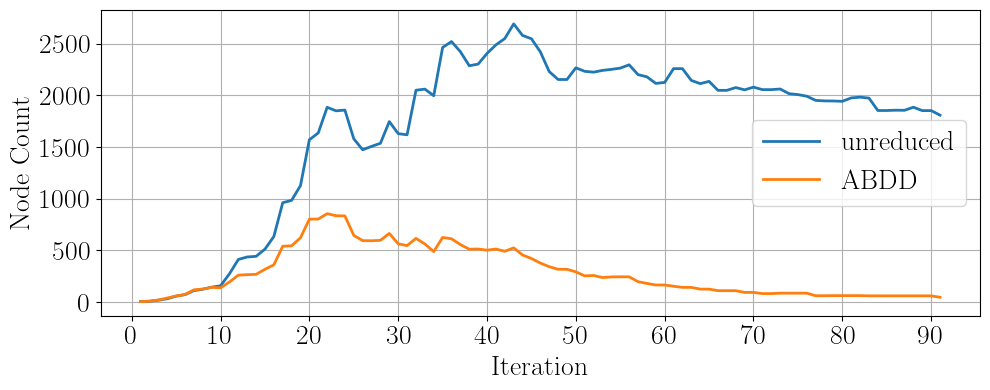

In [8]:

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x+1,
        single_cnf_df['init'],
        label=label_f('init'),
        linewidth=2,
)
ax.plot(x+1,
        single_cnf_df['abdd'],
        label=label_f('abdd'), 
        linewidth=2
)
ax.set_xticks(range(0, len(single_cnf_df), 10))
ax.set_yticks(range(0, max(single_cnf_df['init']), 500))
ax.tick_params(axis='x', labelsize=TEXTSIZE)
ax.tick_params(axis='y', labelsize=TEXTSIZE)
ax.set_xlabel("Iteration", fontsize=TEXTSIZE)
ax.set_ylabel("Node Count", fontsize=TEXTSIZE)
ax.legend(fontsize=TEXTSIZE)
ax.grid(True)

plt.tight_layout()
plt.savefig(f"./figures/one-apply-analysis-vs-unreduced.pdf", format='pdf', dpi=300, facecolor='white', edgecolor='r', bbox_inches='tight', pad_inches=0.02)
plt.show()